In [ ]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
from torchvision import datasets, transforms

%matplotlib inline

In [ ]:
def plot_graphs(log, tpe='loss'):
    keys = log.keys()
    logs = {k:[z for z in zip(*log[k])] for k in keys}
    epochs = {k:range(len(log[k])) for k in keys}
    
    if tpe == 'loss':
        handlers, = zip(*[plt.plot(epochs[k], logs[k][0], label=k)
                          for k in keys])
        plt.title('errors')
        plt.xlabel('epoch')
        plt.ylabel('error')
        plt.legend(handles=handlers)
        plt.show()
        
    elif tpe == 'accuracy':
        handlers, = zip(*[plt.plot(epochs[k], logs[k][1], label=k)
                          for k in log.keys()])
        plt.title('accuracy')
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.legend(handles=handlers)
        plt.show()

## **В качестве датасета используйте MNIST**

In [ ]:
mnist_transform = transforms.Compose([
    transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))
])
path = './MNIST_data'
batch_size = 4

# **Делаем дисбаланс в тренировочном сете - оставляем всего 20 нулей, двоек, троек, остальные цифры не трогаем**

In [ ]:
test_data = datasets.MNIST(path, train=False, download=True, transform=mnist_transform)
train_data = datasets.MNIST(path, train=True, download=True, transform=mnist_transform)

idx = (train_data.targets == 1) | (train_data.targets == 4) | (train_data.targets == 5) | (train_data.targets == 6) | (train_data.targets == 7) | (train_data.targets == 8) | (train_data.targets == 9) 
dataset_train1456789_targets = train_data.targets[idx]
dataset_train1456789_data = train_data.data[idx]
train_data.data = dataset_train1456789_data
train_data.targets = dataset_train1456789_targets

train_data0 = datasets.MNIST(path, train=True, download=True, transform=mnist_transform)
idx = (train_data0.targets == 0)
dataset_train0_targets = train_data0.targets[idx]
dataset_train0_data = train_data0.data[idx]
train_data0.data = dataset_train0_data
train_data0.targets = dataset_train0_targets
train_data0 = torch.utils.data.Subset(train_data0, range(20))

train_data2 = datasets.MNIST(path, train=True, download=True, transform=mnist_transform)
idx = (train_data2.targets == 2)
dataset_train2_targets = train_data2.targets[idx]
dataset_train2_data = train_data2.data[idx]
train_data2.data = dataset_train2_data
train_data2.targets = dataset_train2_targets
train_data2 = torch.utils.data.Subset(train_data2, range(20))

train_data3 = datasets.MNIST(path, train=True, download=True, transform=mnist_transform)
idx = (train_data3.targets == 3)
dataset_train3_targets = train_data3.targets[idx]
dataset_train3_data = train_data3.data[idx]
train_data3.data = dataset_train3_data
train_data3.targets = dataset_train3_targets
train_data3 = torch.utils.data.Subset(train_data3, range(20))

train_data = torch.utils.data.ConcatDataset([train_data, train_data0, train_data2, train_data3])

part_test = torch.utils.data.random_split(test_data, [4000, len(test_data) - 4000])[0]
part_train = torch.utils.data.random_split(train_data, [4000, len(train_data) - 4000])[0]

test_loader = DataLoader(part_test, batch_size=batch_size, shuffle=False)
train_loader = DataLoader(part_train, batch_size=batch_size, shuffle=True)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST_data/MNIST/raw



In [ ]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [ ]:
example_data.shape

torch.Size([4, 1, 28, 28])

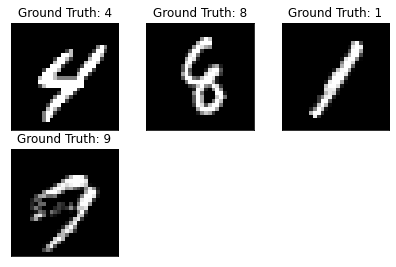

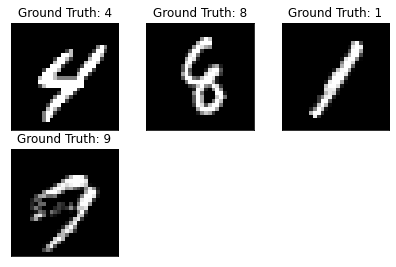

In [ ]:
fig = plt.figure()
for i in range(4):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [ ]:
def train(models, loader, epoch, log=None):
    train_size = len(loader.sampler)
    for batch_idx, (data, target) in enumerate(loader):
        for model in models.values():
            model.optim.zero_grad()
            output = model(data)
            loss = model.loss(output, target)
            loss.backward()
            model.optim.step()
            
        if batch_idx % 2000 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append((models[k]._loss, models[k]._correct))
        print(line + losses)

In [ ]:
def test(models, loader, log=None):
    test_size = len(loader.sampler)
    avg_lambda = lambda l: 'Loss: {:.4f}'.format(l)
    acc_lambda = lambda c, p: 'Accuracy: {}/{} ({:.0f}%)'.format(c, test_size, p)
    line = lambda i, l, c, p: '{}: '.format(i) + avg_lambda(l) + '\t' + acc_lambda(c, p)

    test_loss = {k: 0. for k in models}
    correct = {k: 0. for k in models}
    with torch.no_grad():
        for data, target in loader:
            output = {k: m(data) for k, m in models.items()}
            for k, m in models.items():
                test_loss[k] += m.loss(output[k], target, reduction='sum').item() # sum up batch loss
                pred = output[k].data.max(1, keepdim=True)[1] # get the index of the max log-probability
                correct[k] += pred.eq(target.data.view_as(pred)).cpu().sum()
    
    for k in models:
        test_loss[k] /= test_size
    correct_pct = {k: c.to(torch.float) / test_size for k, c in correct.items()}
    lines = '\n'.join([line(k, test_loss[k], correct[k], 100*correct_pct[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines
    if log is not None:
        for k in models:
            log[k].append((test_loss[k], correct_pct[k]))
    print(report)

In [ ]:
class Net4(nn.Module):
    def __init__(self,
                 batchnorm=False,
                 dropout=False,
                 lr=1e-4, l2=0.):
        super(Net4, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 256)
        self.fc4 = nn.Linear(256, 128)
        self.fc5 = nn.Linear(128, 128)
        self.fc6 = nn.Linear(128, 10)
        if batchnorm:
            self.bn = nn.BatchNorm1d(128)
        else:
            self.bn = lambda x: x
        if dropout:
            self.dropout = nn.Dropout(0.2)
        else:
            self.dropout = lambda x: x
        self.optim = optim.SGD(self.parameters(), lr=lr, weight_decay=l2)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.bn(x)
        x = F.relu(self.fc5(x))
        x = self.dropout(x)
        x = self.fc6(x)
        x = F.log_softmax(x, dim=1)
        return x

    def loss(self, output, target, **kwargs):
        self._loss = F.nll_loss(output, target, **kwargs)
        pred = output.data.max(1, keepdim=True)[1]
        t = target.data.view_as(pred)
        self._correct = pred.eq(t).to(torch.float).mean()
        return self._loss

In [ ]:
models = {'default': Net4()}
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [ ]:
for epoch in range(1, 101):
    for model in models.values():
        model.train()
    train(models, train_loader, epoch, train_log)
    for model in models.values():
        model.eval()
    test(models, test_loader, test_log)

Train Epoch: 1 [0/4000 (0%)]	Losses default: 2.289735
Train Epoch: 1 [4000/4000 (100%)]	Losses default: 2.259138
Test set:
default: Loss: 2.3029	Accuracy: 382.0/4000 (10%)

Train Epoch: 2 [0/4000 (0%)]	Losses default: 2.278473
Train Epoch: 2 [4000/4000 (100%)]	Losses default: 2.306255
Test set:
default: Loss: 2.3031	Accuracy: 382.0/4000 (10%)

Train Epoch: 3 [0/4000 (0%)]	Losses default: 2.290504
Train Epoch: 3 [4000/4000 (100%)]	Losses default: 2.290105
Test set:
default: Loss: 2.3034	Accuracy: 382.0/4000 (10%)

Train Epoch: 4 [0/4000 (0%)]	Losses default: 2.271936
Train Epoch: 4 [4000/4000 (100%)]	Losses default: 2.258239
Test set:
default: Loss: 2.3037	Accuracy: 382.0/4000 (10%)

Train Epoch: 5 [0/4000 (0%)]	Losses default: 2.237635
Train Epoch: 5 [4000/4000 (100%)]	Losses default: 2.260243
Test set:
default: Loss: 2.3041	Accuracy: 382.0/4000 (10%)

Train Epoch: 6 [0/4000 (0%)]	Losses default: 2.271243
Train Epoch: 6 [4000/4000 (100%)]	Losses default: 2.278387
Test set:
default: Los

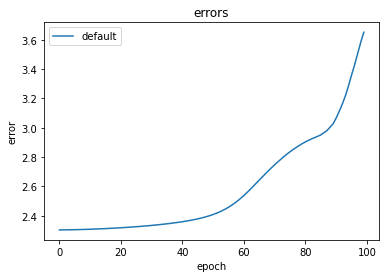

In [ ]:
plot_graphs(test_log, 'loss')

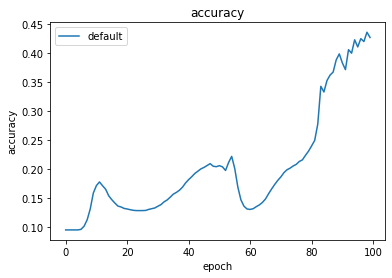

In [ ]:
plot_graphs(test_log, 'accuracy')

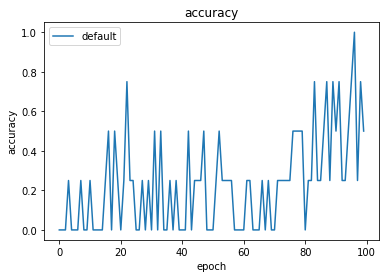

In [ ]:
plot_graphs(train_log, 'accuracy')